<a href="https://colab.research.google.com/github/kylemcdonald/FaceStatistics/blob/master/Align_and_Average_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# this whole process can take 10-15 minutes, mainly because installing dlib is slow
!apt update -qq
!apt install -qq cmake ffmpeg
!pip install dlib
![[ ! -e shape_predictor_5_face_landmarks.dat.bz2 ]] && \
  wget -c 'http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2' && \
  bunzip2 shape_predictor_5_face_landmarks.dat.bz2
![[ ! -e utils ]] && \
  git clone https://github.com/kylemcdonald/python-utils -b show_array utils
![[ ! -e FaceStatistics ]] && \
  git clone https://github.com/kylemcdonald/FaceStatistics.git && \
  cp -r FaceStatistics/model .

In [0]:
# uploading 50MB of images can take 4-5 minutes
from google.colab import files
upload = files.upload()

Saving images.zip to images.zip


In [0]:
upload_fn = list(upload.keys())[0]
!rm -rf images
!unzip -q {upload_fn} -d images
!echo 'Total images:' `ls images | wc -l`

Total images: 400


In [0]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from itertools import islice, chain
from IPython.display import clear_output
import numpy as np
import os
import dlib
import keras

from utils.list_all_files import *
from utils.show_array import *
from utils.imutil import *
from utils.imwarp import *
from utils.center_crop import *
from utils.mosaic import *
from utils.progress import progress

In [0]:
# creates an average image from a folder of images that are all the same size
def average_folder(fn, limit=None):
    accumulated = None
    total = 0
    filenames = list(list_all_files(fn))
    filenames = filenames[:limit]
    for fn in progress(filenames):
        try:
            img = imread(fn, mode='rgb')
            if accumulated is None:
                accumulated = np.zeros(img.shape, dtype=np.float32)
            accumulated += img
            total += 1
        except KeyboardInterrupt:
            break
        except:
            pass
    avg = accumulated / total
    return avg

def to_np(pt):
    return np.array([pt.y, pt.x])

def safe_crop(img, top, bottom, left, right):
    top, bottom = np.clip((top, bottom), 0, img.shape[0]-1)
    left, right = np.clip((left, right), 0, img.shape[1]-1)
    return img[top:bottom, left:right]

def crop_face(img, parts):
    right_eye = (to_np(parts[0]) + to_np(parts[1])).astype('float') / 2
    left_eye = (to_np(parts[2]) + to_np(parts[3])).astype('float') / 2
    nose = to_np(parts[4])
    pivot = (left_eye + right_eye) / 2
    nose_angle = 90 + np.rad2deg(np.arctan2(pivot[0] - nose[0], pivot[1] - nose[1]))
    eye_angle = np.rad2deg(np.arctan2(right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]))
    angle = (nose_angle + eye_angle) / 2
    rotated = rotate_image(img, eye_angle, pivot=pivot)
    scale = np.linalg.norm(right_eye - left_eye)
    y = int(pivot[0] + scale * 0.4)
    x = int(pivot[1])
    r = int(scale * 2)
    center = pivot.astype('int')
    cropped = safe_crop(rotated, y-r, y+r, x-r, x+r)
    return cropped

def align_folder(input_folder, output_folder, output_size=256):
    print('Loading face detector and landmark detector...')
    detector = dlib.get_frontal_face_detector()
    shape_predictor_5 = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

    invalid = []
    no_face = []
    small_image = []
    aligned = []
    os.makedirs(output_folder, exist_ok=True)
    filenames = list(list_all_files(input_folder))
    for fn in progress(filenames):
        try:
            img = imread(fn, mode='rgb')
            if img is None: # ignore images that don't load correctly
                invalid.append(fn)
                continue
            boxes = detector(img)
            if len(boxes) == 0: # ignore images without faces
                no_face.append(fn)
                continue
            box = boxes[0]
            cur = img[box.top():box.bottom(), box.left():box.right()]
            shape = shape_predictor_5(img, box)
            cropped = crop_face(img, shape.parts())
            if cropped.shape[0] != cropped.shape[1]:
                cropped = center_crop(cropped)
            if cropped.shape[0] < 64: # ignore non-square and small images
                small_image.append(fn)
                continue
            resized = imresize(cropped, output_wh=(output_size, output_size))
            imwrite(os.path.join(output_folder, os.path.basename(fn)), resized)
            aligned.append(fn)
        except KeyboardInterrupt:
            break
        except:
            pass

    print(len(aligned), 'images successfully aligned.')
    if len(invalid) > 0:
        print(len(invalid), 'images could not be loaded. Example:', invalid[0])
    if len(no_face) > 0:
        print(len(no_face), 'images contained no faces. Example:', no_face[0])
    if len(small_image) > 0:
        print(len(small_image), 'images contained very small faces. Example:', small_image[0])

In [0]:
# align all the faces in the folder input/
# and save the results in aligned/
# takes around 3 minutes for 400 images
align_folder('images', 'aligned')

400 0:03:43 1.80/s
386 images successfully aligned.
14 images contained no faces. Example: images/15.17.32.952.jpg


386 0:00:01 616.62/s


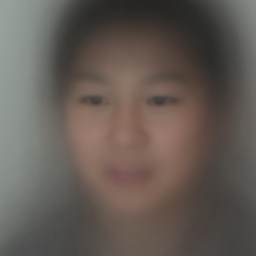

In [0]:
avg = average_folder('aligned')
show_array(avg)

In [0]:
# generate a 24fps video containing all the images in aligned/
!ffmpeg -y -r 24 -pattern_type glob -i 'aligned/*.jpg' -r 24 -pix_fmt yuv420p aligned.mp4

ffmpeg version 3.4.4-0ubuntu0.18.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
files.download('aligned.mp4')

In [0]:
labels = open('model/labels.txt').read().splitlines()
model = keras.models.load_model('model/model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def chunks(iterable, size=10):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))
        
filenames = list(list_all_files('aligned'))

results = []
batch_size = 16
for chunk in chunks(progress(filenames), batch_size):
    images = [imresize(imread(fn), max_side=96) for fn in chunk]
    batch = np.asarray(images).astype(np.float32) / 255.
    result = model.predict(batch)
    results.extend(result)
results = np.asarray(results)

386 0:00:04 93.77/s


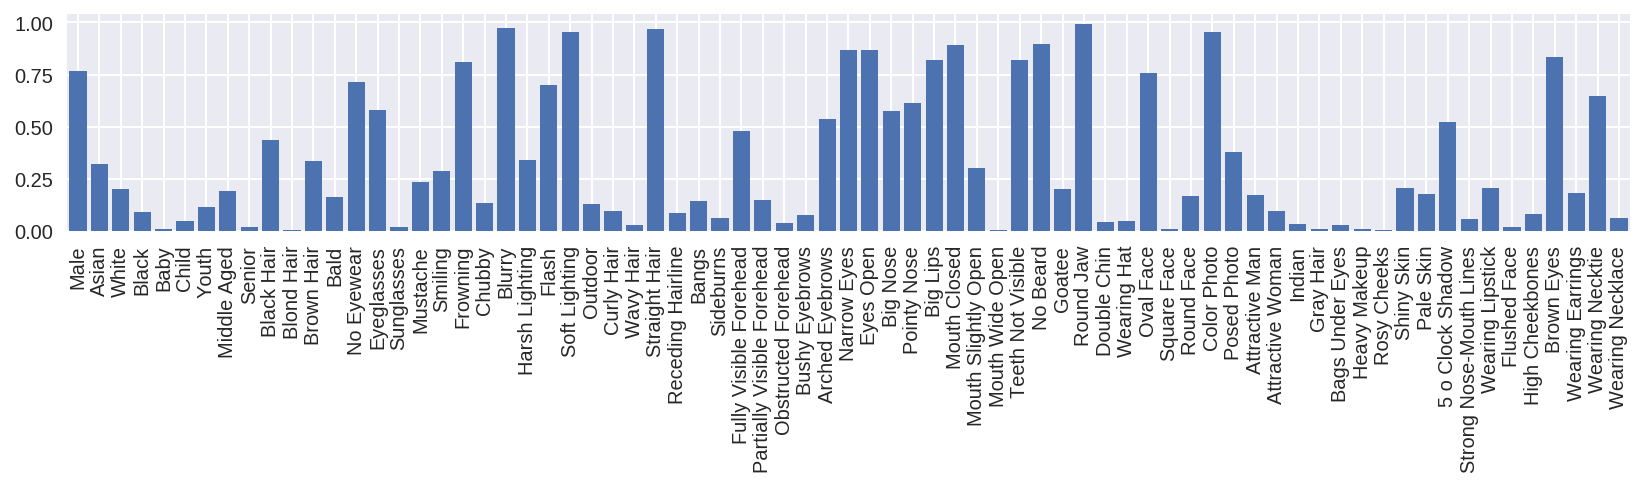

In [0]:
plt.figure(figsize=(14,2))
n = len(labels)
x = np.arange(n) + 0.5
plt.bar(x, results[0])
plt.xticks(x, labels, rotation=90)
plt.xlim(0, n)
plt.show()

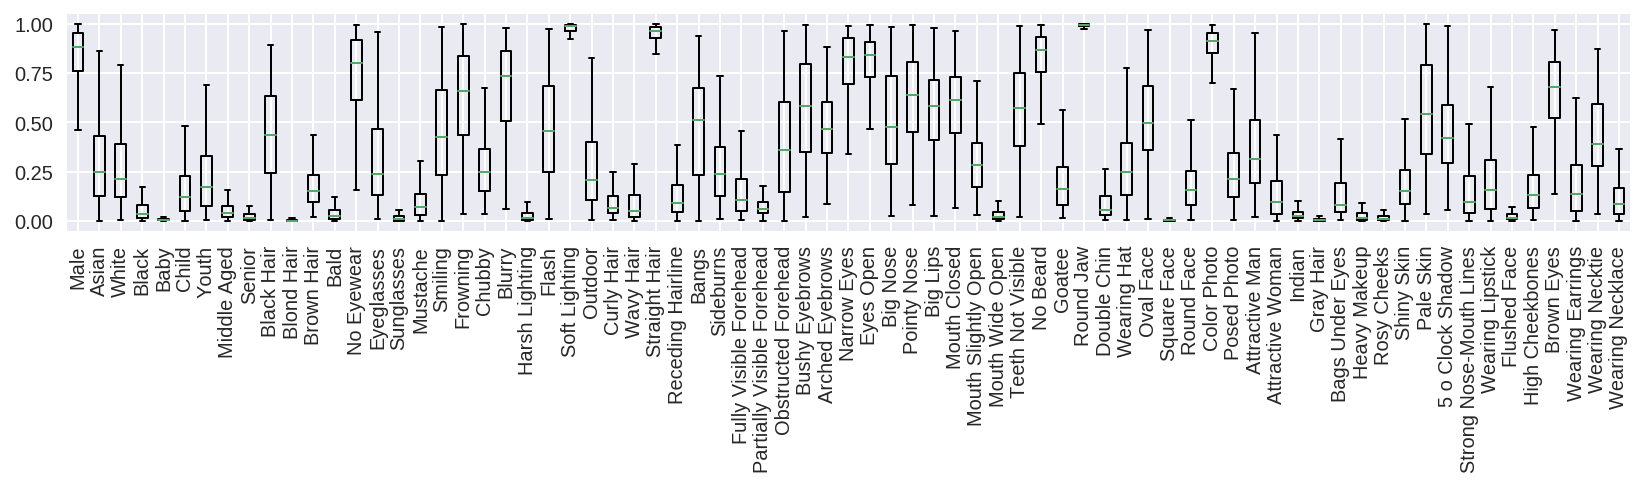

In [0]:
plt.figure(figsize=(14,2))
plt.boxplot(results, showfliers=False)
plt.xticks(x + 0.5, labels, rotation=90)
plt.show()

In [0]:
means = results.mean(axis=0)
stds = results.std(axis=0)
for label, mean, std in zip(labels, means, stds):
    print(f'{mean*100:02.0f}% ±{std*100:02.0f}% {label}')

82% ±19% Male
29% ±20% Asian
29% ±22% White
06% ±05% Black
01% ±01% Baby
16% ±13% Child
23% ±19% Youth
06% ±05% Middle Aged
04% ±07% Senior
44% ±23% Black Hair
01% ±01% Blond Hair
18% ±11% Brown Hair
05% ±06% Bald
72% ±26% No Eyewear
32% ±25% Eyeglasses
03% ±04% Sunglasses
12% ±15% Mustache
45% ±26% Smiling
62% ±25% Frowning
28% ±17% Chubby
66% ±25% Blurry
04% ±06% Harsh Lighting
46% ±25% Flash
96% ±08% Soft Lighting
27% ±20% Outdoor
10% ±10% Curly Hair
12% ±17% Wavy Hair
94% ±09% Straight Hair
16% ±18% Receding Hairline
46% ±26% Bangs
27% ±18% Sideburns
19% ±21% Fully Visible Forehead
08% ±07% Partially Visible Forehead
38% ±26% Obstructed Forehead
56% ±27% Bushy Eyebrows
48% ±17% Arched Eyebrows
77% ±20% Narrow Eyes
81% ±13% Eyes Open
51% ±26% Big Nose
62% ±22% Pointy Nose
56% ±20% Big Lips
58% ±20% Mouth Closed
30% ±16% Mouth Slightly Open
04% ±06% Mouth Wide Open
56% ±24% Teeth Not Visible
82% ±17% No Beard
21% ±16% Goatee
99% ±02% Round Jaw
11% ±13% Double Chin
28% ±18% Wearing Ha